# Zestaw 3
## Kompresja tekstu
### Kamil Burkiewicz

#### Imports

In [1]:
from bitarray import bitarray
from time import time
import os

# Visualization

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from queue import LifoQueue as queue

In [3]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, leaf_vs_root_factor = 0.5):

    '''
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    Based on Joel's answer at https://stackoverflow.com/a/29597209/2966723,
    but with some modifications.  

    We include this because it may be useful for plotting transmission trees,
    and there is currently no networkx equivalent (though it may be coming soon).
    
    <...>  
    
    :Arguments: 
    
    **G** the graph (must be a tree)

    **root** the root node of the tree 
    - if the tree is directed and this is not given, the root will be found and used
    - if the tree is directed and this is given, then the positions will be 
      just for the descendants of this node.
    - if the tree is undirected and not given, then a random choice will be used.

    **width** horizontal space allocated for this branch - avoids overlap with other branches

    **vert_gap** gap between levels of hierarchy

    **vert_loc** vertical location of root
    
    **leaf_vs_root_factor**

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, leftmost, width, leafdx = 0.2, vert_gap = 0.2, vert_loc = 0, 
                    xcenter = 0.5, rootpos = None, 
                    leafpos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if rootpos is None:
            rootpos = {root:(xcenter,vert_loc)}
        else:
            rootpos[root] = (xcenter, vert_loc)
        if leafpos is None:
            leafpos = {}
        children = list(G.neighbors(root))
        leaf_count = 0
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            rootdx = width/len(children)
            nextx = xcenter - width/2 - rootdx/2
            for child in children:
                nextx += rootdx
                rootpos, leafpos, newleaves = _hierarchy_pos(G,child, leftmost+leaf_count*leafdx, 
                                    width=rootdx, leafdx=leafdx,
                                    vert_gap = vert_gap, vert_loc = vert_loc-vert_gap, 
                                    xcenter=nextx, rootpos=rootpos, leafpos=leafpos, parent = root)
                leaf_count += newleaves

            leftmostchild = min((x for x,y in [leafpos[child] for child in children]))
            rightmostchild = max((x for x,y in [leafpos[child] for child in children]))
            leafpos[root] = ((leftmostchild+rightmostchild)/2, vert_loc)
        else:
            leaf_count = 1
            leafpos[root]  = (leftmost, vert_loc)
            
        return rootpos, leafpos, leaf_count

    xcenter = width/2.
    if isinstance(G, nx.DiGraph):
        leafcount = len([node for node in nx.descendants(G, root) if G.out_degree(node)==0])
    elif isinstance(G, nx.Graph):
        leafcount = len([node for node in nx.node_connected_component(G, root) if G.degree(node)==1 and node != root])
    rootpos, leafpos, leaf_count = _hierarchy_pos(G, root, 0, width, 
                                                    leafdx=width*1./leafcount, 
                                                    vert_gap=vert_gap, 
                                                    vert_loc = vert_loc, 
                                                    xcenter = xcenter)
    pos = {}
    for node in rootpos:
        pos[node] = (leaf_vs_root_factor*leafpos[node][0] + (1-leaf_vs_root_factor)*rootpos[node][0], leafpos[node][1]) 
    xmax = max(x for x,y in pos.values())
    for node in pos:
        pos[node]= (pos[node][0]*width/xmax, pos[node][1])
    return pos

In [4]:
# separator chosen so that the helper part of the labeling is hidden
separator = " " * 44

def flatten_tree(tree):
    q = queue()
    q.put(tree.root)
    nodes = []
    
    while (not q.empty()):
        node = q.get()
        nodes += [node]
        if (node.left is not None):
            q.put(node.left)
        if (node.right is not None):
            q.put(node.right)
            
    return nodes

def visualize(tree, width=6.4, height=4.8, title=None, color="gold"):
    """
    Simple tree visualization.
    Tree is any tree structure having a attribute root.
    Its nodes have to have right and left attributes and no child
    should be marked as None.
    """
    G = nx.Graph()
    nodes = flatten_tree(tree)
    nrs = {}
    size=[width, height]
    
    def node_repr(v, i):
        letter = v.letter if v.letter != EOF else "EOF"
        return str(v.counter) + "\n" + letter + "\n" + separator * int(width) + str(i)
    
    # Add nodes
    for i, v in enumerate(nodes):
        G.add_node(node_repr(v, i))
        nrs[v] = i
    
    # Add all edges
    edge_labels = {}
    for i, v in enumerate(nodes):
        if (v.left is not None):
            G.add_edge(node_repr(v, i), node_repr(v.left, nrs[v.left]))
            edge_labels[(node_repr(v, i), node_repr(v.left, nrs[v.left]))] = " 0 "
        if (v.right is not None):
            G.add_edge(node_repr(v, i), node_repr(v.right, nrs[v.right]))
            edge_labels[(node_repr(v, i), node_repr(v.right, nrs[v.right]))] = " 1 "

    plt.figure(3, figsize=size)
    plt.title(title)
    if (tree.root.left is not None or tree.root.right is not None):
        pos = hierarchy_pos(G, node_repr(tree.root, 0))
    else:
        pos = None
    nx.draw(G, pos=pos, with_labels=True, node_color=color, edge_color="dodgerblue",
            font_size="13")
    nx.draw_networkx_edge_labels(G, pos=pos, font_color='black', edge_labels=edge_labels)
    plt.show()

## Opracować format pliku przechowującego dane

In [5]:
# Special "characters"

# EOF: Unicode private area character used as
# a terminating character for every string.
# If it had not been used, the decoding from file
# would be impossible. That is because files
# are byte adjusted, so if the number of
# encoded bits is not a multiple of 8,
# the additional bits are added at the end.
# Situation like this causes a modification of
# an original text (and sometimes errors).
EOF = chr(0xE000)

# internal_sign: A "letter" used by internal nodes.
internal_sign = " " * 3

# NYT: Not yet transferred
NYT = "NYT"

## Drzewo Huffmana

In [22]:
class HuffmanTree:
    def __init__(self):
        self.root = None
        self.max_depth = 0
        self.codes = {}
    
    @classmethod
    def build_static_from_text(cls, text):
        """
        Method builds staticaly a Huffman tree using a previously
        calculating quantities of all letters in the text.
        This method works as a constructor.
        
        Args:
            text(string): Just a text.
            
        Returns:
            HuffmanTree(obj): Built Huffman tree.
        """
        
        letters_count = HuffmanTree._count_letters(cls, text)
        return cls.build_static(letters_count)
    
    @classmethod
    def build_static(cls, letters_count):
        """
        Method builds staticaly a Huffman tree having a dictionary
        of a quantities of letters.
        This method works as a constructor.
        
        Args:
            letters_count(dict): A dictionary storing quantities of letters.
            
        Returns:
            HuffmanTree(obj): Built Huffman tree.
        """
        
        tree = HuffmanTree()
        
        if (EOF not in letters_count):
            letters_count[EOF] = 1
            
        nodes = [Node(letter=a, counter=letters_count[a]) for a in letters_count]
        
        internal_nodes = []
        leafs = sorted(nodes, key=lambda n: n.counter)
        while(len(leafs) + len(internal_nodes) > 1):
            head = []
            if(len(leafs) >= 2):
                head += leafs[:2]
            elif(len(leafs) == 1):
                head += leafs[:1]
            if(len(internal_nodes) >= 2):
                head += internal_nodes[:2]
            elif(len(internal_nodes) == 1):
                head += internal_nodes[:1]
                
            element_1, element_2 = sorted(head, key=lambda n: n.counter)[:2]
            internal_nodes += [Node(counter=element_1.counter + element_2.counter)]
            internal_nodes[-1].left = element_1
            internal_nodes[-1].right = element_2
            element_1.parent = internal_nodes[-1]
            element_2.parent = internal_nodes[-1]
            
            if(len(leafs) > 0 and element_1 == leafs[0]):
                leafs = leafs[1:]
            else:
                internal_nodes = internal_nodes[1:]
            if(len(leafs) > 0 and element_2 == leafs[0]):
                leafs = leafs[1:]
            else:
                internal_nodes = internal_nodes[1:]
                
            tree.max_depth += 1
            
        tree.root = internal_nodes[0]
        tree._get_codes()
        
        return tree
    
    @classmethod
    def build_dynamically(cls, text, vitter_workalike=False):
        """
        Method builds dynamically the Huffman tree.
        This method works as a constructor.
        
        Args:
            text: Text.
            vitter_workalike: Vitter's algorithm work-lookalike.
                              It is turns on the mode of working similarly
                              to Vitter's algorithm. While swapping there is
                              a search for an optimal node to swap.
                              It is using brute force search of all nodes.
        Returns:
            HuffmanTree(obj): Built Huffman tree.                  
        """
        
        text += str(EOF)
        
        tree = HuffmanTree()
        nodes = {NYT: Node(letter=NYT, counter=0)}
        tree.root = nodes[NYT]
        
        for letter in text:
            if letter in nodes:
                node = nodes[letter]
                node.increment(tree, vitter_workalike)
            else:
                updated_node = nodes[NYT]
                node = Node(letter=letter, parent=updated_node, counter=1)
                nodes[letter] = node
                zero_node = Node(NYT, parent=updated_node, counter=0)
                updated_node.left = zero_node
                updated_node.right = node
                updated_node.letter = internal_sign
                nodes[NYT] = zero_node
                updated_node.increment(tree, vitter_workalike)
                
                tree.max_depth += 1
    
        tree._get_codes()
    
        return tree
    
    def search_counter(self, counter):
        l_node, l_level = None, None
        r_node, r_level = None, None
        if (self.root.left):
            l_node, l_level = self.root.left._search_counter(counter, 1)
        if (self.root.right):
            r_node, r_level = self.root.right._search_counter(counter, 1)
        
        if (l_node is not None and r_node is not None):
            if (l_level < r_level):
                return l_node
            else:
                return r_node

        if (r_node is not None):
            return r_node
        return l_node
    
    def _count_letters(self, text):
        """
        Function counts letters in a text.
        
        Args:
            text: A string to process.
        
        Returns:
            dict: The dictionary having a counter for each letter in text.
        """

        letters_count = {}
        
        for letter in text:
            if (letter in letters_count):
                letters_count[letter] += 1
            else:
                letters_count[letter] = 1
        
        return letters_count
    
    def _get_codes(self):
        """
        Fill a dictionary of Huffman codes.
        """
        
        stack = [0] * self.max_depth
        self.__recursive_codes(self.root, stack, 0, self.codes)
        
    def __recursive_codes(self, node, stack, depth, codes):
        """
        Helper method for a _get_codes() method.
        """

        if (node.letter is internal_sign):
            stack[depth] = 0
            self.__recursive_codes(node.left, stack, depth + 1, codes)
            stack[depth] = 1
            self.__recursive_codes(node.right, stack, depth + 1, codes)
        elif (node.letter is not NYT):
            codes[node.letter] = bitarray(stack[: depth]) 
    
    def encode(self, text):
        """
        Method changes the text to a bit representation.
        
        Examples:
        Assume codes are given as follows:
        {'a' : 0, 'b' : 11, EOF : 10}
        
        >>> tree.encode("baab") # 11 0 0 11 10
        bitarray('11001110')
        >>> tree.encode("abab") # 0 11 0 11 10
        bitarray('01101110')
        
        Args:
            text(string): A text to be encoded using the Huffman tree.
        
        Returns:
            bitarray: A bitarray representing the text in Huffman coding.
        """
        
        if (not self.codes):
            self._get_codes()

        result = bitarray([])
        for letter in text:
            if (letter not in self.codes):
                raise Exception("Letter of a text not in a tree.")
            result += self.codes[letter]
        
        return result + self.codes[EOF]
    
    def decode(self, barray):
        """
        Method changes the bitarrray to a string.
        If bitarray does not have a required structure, 
        raising an exception is likely to happen. (likely
        because random bitarray still can be decoded if
        it ends in a terminating sequence)
        
        Example:
        Assume codes are given as follows:
        {'a' : 0, 'b' : 11, EOF : 10}
        
        >>> tree.decode(bitarray('11011010')) # 11 0 11 0 10 
        'baba'
        >>> tree.decode(bitarray('01111010')) # 0 11 11 0 10
        'abba'
        
        Args:
            barray(bitarray): An encoded bitarray.
        
        Returns:
            string: A text encoded in bitarray.
        """
        
        if (self.root is None):
            raise Exception("Tree is not built.")
        
        node = self.root
        
        result = ""
        barray_len = len(barray)
        i = 0

        while (i < barray_len):
            if (barray[i] == 0):
                node = node.left
            else:
                node = node.right
            
            if (node.letter == EOF):
                return result
            
            if (node.letter != internal_sign):
                result += node.letter
                node = self.root
            
            i += 1
            
        raise Exception("Invalid argument")
 
    def print_tree(self):
        self.root.print_subtree(0, "root")
    
class Node:
    def __init__(self, letter=internal_sign, counter=0, left=None, right=None, parent=None):
        self.counter = counter
        self.letter = letter
        self.left = left
        self.right = right
        self.parent = parent
    
    def __str__(self):
        if (self.letter == internal_sign):
            return f": {self.counter}"
        return f"'{self.letter}' : {self.counter}"
    
    def print_subtree(self, indent, direction):
        print(direction, end=" ")
        print(indent * ">", end=" ")
        print(self)
        if (self.left):
            self.left.print_subtree(indent + 1, "l")
        if (self.right):
            self.right.print_subtree(indent + 1, "r")
            
    def increment(self, tree, vitter_workalike=False):
        curr = self
        while (curr.parent):            
            highest = curr
            
            # siblings check for swap
            curr_sibling = curr.sibling()
            parent_sibling = curr.parent.sibling()
            if (curr_sibling and curr.counter == curr_sibling.counter):
                highest = curr_sibling
            if (parent_sibling and curr.counter == parent_sibling.counter):
                highest = parent_sibling
            
            #
            # In Vitter's algorithm there is an optimized search for the best swap.
            # To turn on search for the optimum node to swap
            # pass the True value to the constructor build_dynamically().
            # Here is Duke University site, which says that FGK algorithm needs only siblings
            # check(https://www2.cs.duke.edu/csed/curious/compression/adaptivehuff.html).
            # This method gives up on optimal height in exchange for general speed of
            # an algorithm.
            # 
            if (vitter_workalike):
                highest = tree.search_counter(curr.counter)
            
            curr.swap(highest)       
            curr.counter += 1
            curr = curr.parent

        # increment root
        curr.counter += 1

    def swap(self, other):
        if (other and other.parent and self.parent and self is not other):
            self_par = self.parent
            other_par = other.parent
        
            if (other_par.left is other):
                other_par.left = self
            else:
                other_par.right = self
            if (self_par.left is self):
                self_par.left = other
            else:
                self_par.right = other
            
            self.parent = other_par
            other.parent = self_par
    
    def sibling(self):
        if (self.parent):
            if (self.parent.left is self):
                return self.parent.right
            else:
                return self.parent.left
        else:
            return None
    
    def _search_counter(self, counter, level):
        if (self.counter == counter):
            return self, level
        
        # Highest order nodes of the left and right subtree of a given node.
        # They have counter equal to the value of variable counter.
        # Here are also levels of the nodes from the root down.
        l_node, l_level = None, None
        r_node, r_level = None, None
        if (self.left):
            l_node, l_level = self.left._search_counter(counter, level + 1)
        if (self.right):
            r_node, r_level = self.right._search_counter(counter, level + 1)
        
        if (l_node and r_node):
            if (r_level > l_level):
                return l_node, l_level
            else:
                return r_node, r_level
        if (r_node is not None):
            return r_node, r_level
        return l_node, l_level
    
    def code(self):
        if (self.parent is None): return ""
        par_code = self.parent.code()
        if (self == self.parent.right): return par_code +"1"
        else: return par_code + "0"


### Testing

In [7]:
test_text = "abracadabra"

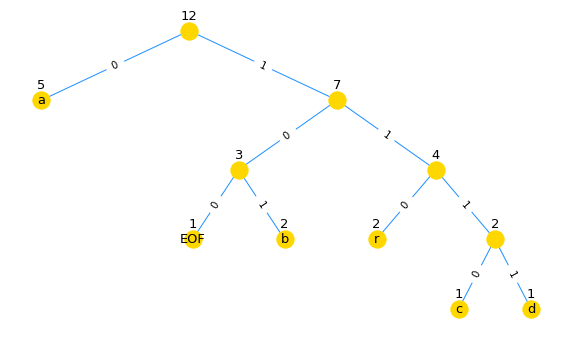

In [8]:
static_tree = HuffmanTree.build_static_from_text(test_text)
visualize(static_tree, width=10, height=6)

In [9]:
encoded_statically = static_tree.encode(test_text)
print(encoded_statically)
print(f"decoded:\t{static_tree.decode(encoded_statically)}")
print(f"original:\t{test_text}")

bitarray('0101110011100111101011100100')
decoded:	abracadabra
original:	abracadabra


In [10]:
static_tree.print_tree()

root  : 12
l > 'a' : 5
r > : 7
l >> : 3
l >>> '' : 1
r >>> 'b' : 2
r >> : 4
l >>> 'r' : 2
r >>> : 2
l >>>> 'c' : 1
r >>>> 'd' : 1


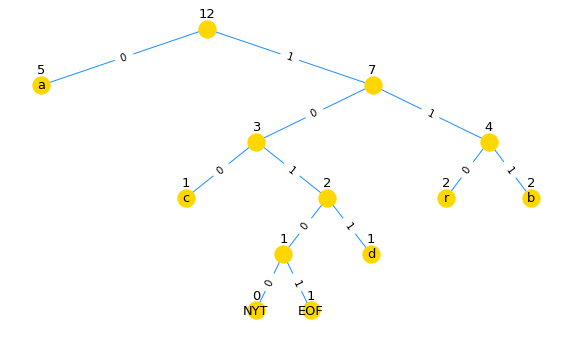

In [11]:
adaptive_tree = HuffmanTree.build_dynamically(test_text)
visualize(adaptive_tree, width=10, height=6)

In [12]:
encoded_dynamically = adaptive_tree.encode(test_text)
print(encoded_dynamically)
print(f"decoded:\t{adaptive_tree.decode(encoded_dynamically)}")
print(f"original:\t{test_text}")

bitarray('01111100100010110111110010101')
decoded:	abracadabra
original:	abracadabra


In [13]:
adaptive_tree.print_tree()

root  : 12
l > 'a' : 5
r > : 7
l >> : 3
l >>> 'c' : 1
r >>> : 2
l >>>> : 1
l >>>>> 'NYT' : 0
r >>>>> '' : 1
r >>>> 'd' : 1
r >> : 4
l >>> 'r' : 2
r >>> 'b' : 2


				Large tree structures for a Huffman coding of a file of size 1kB


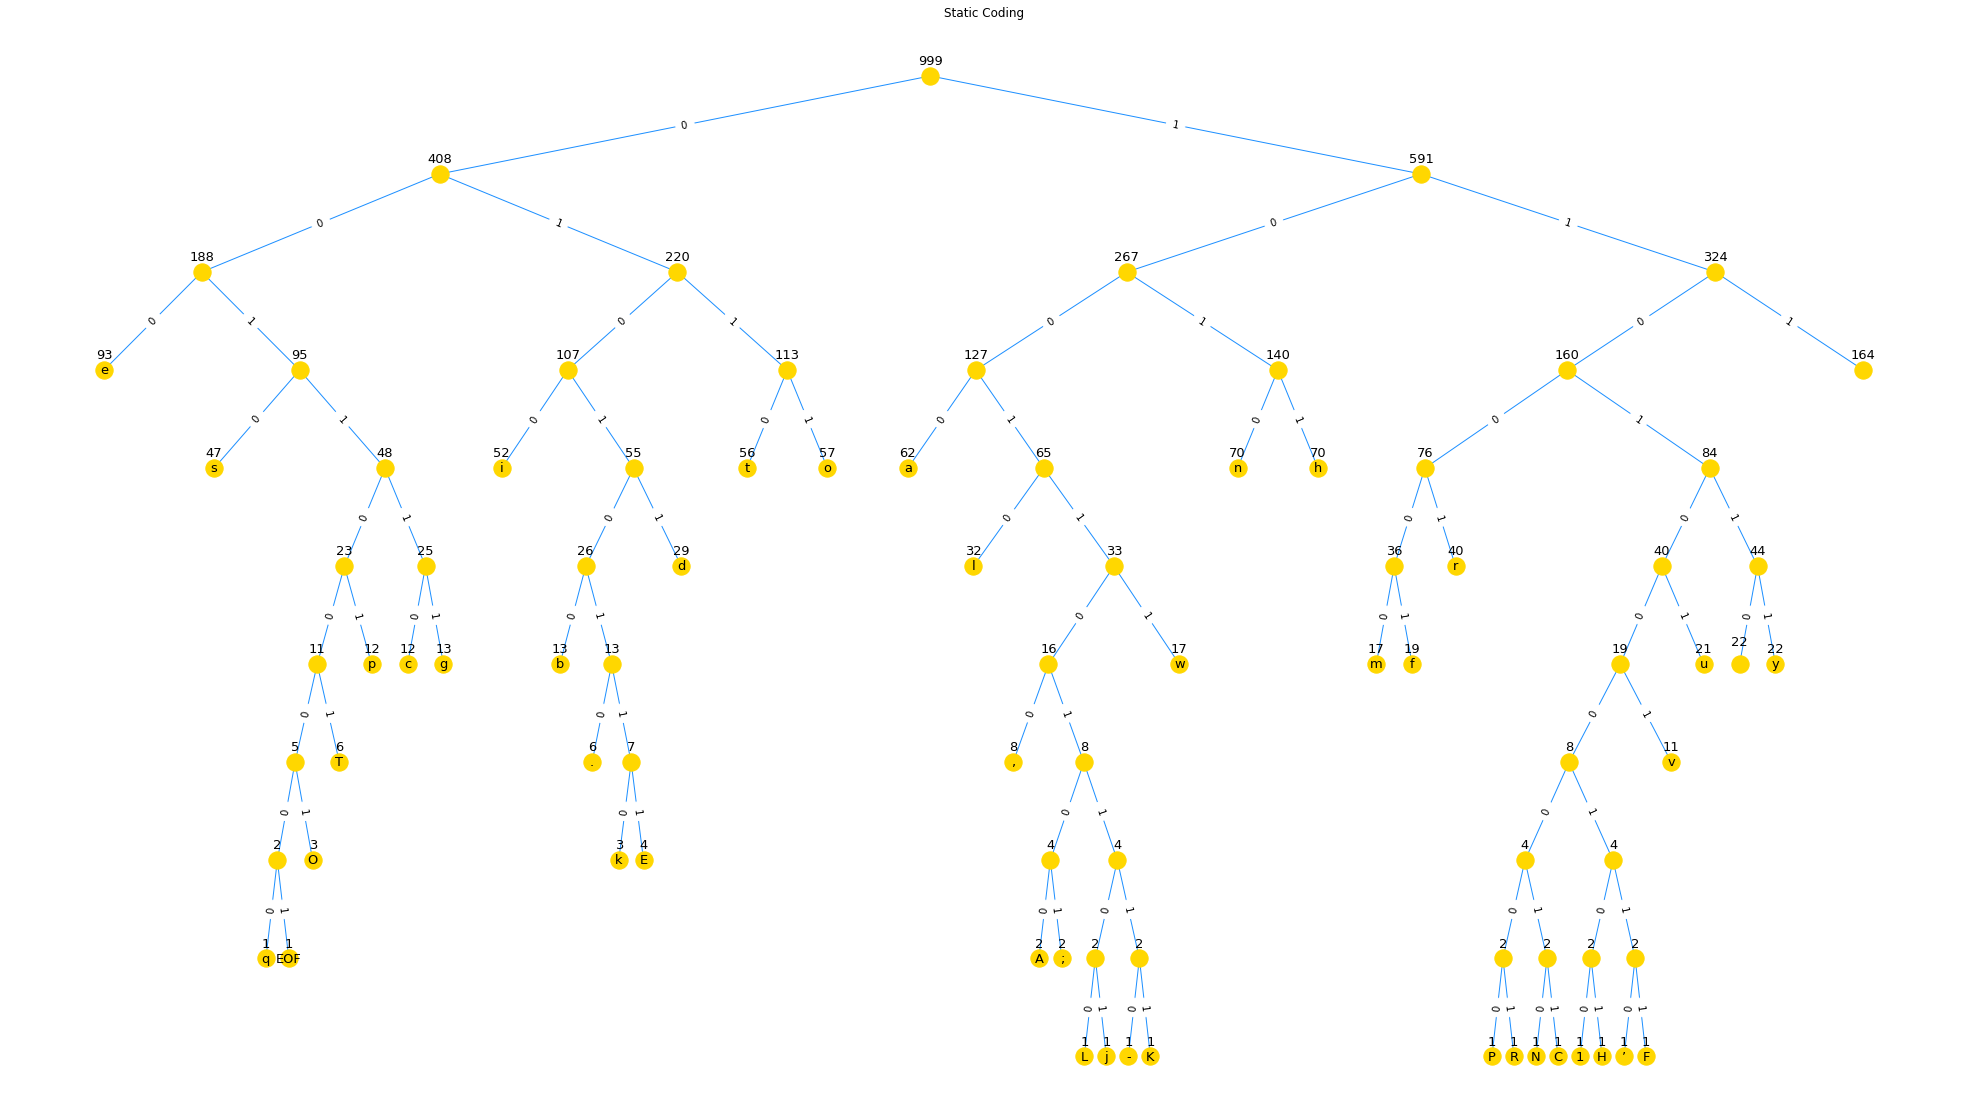

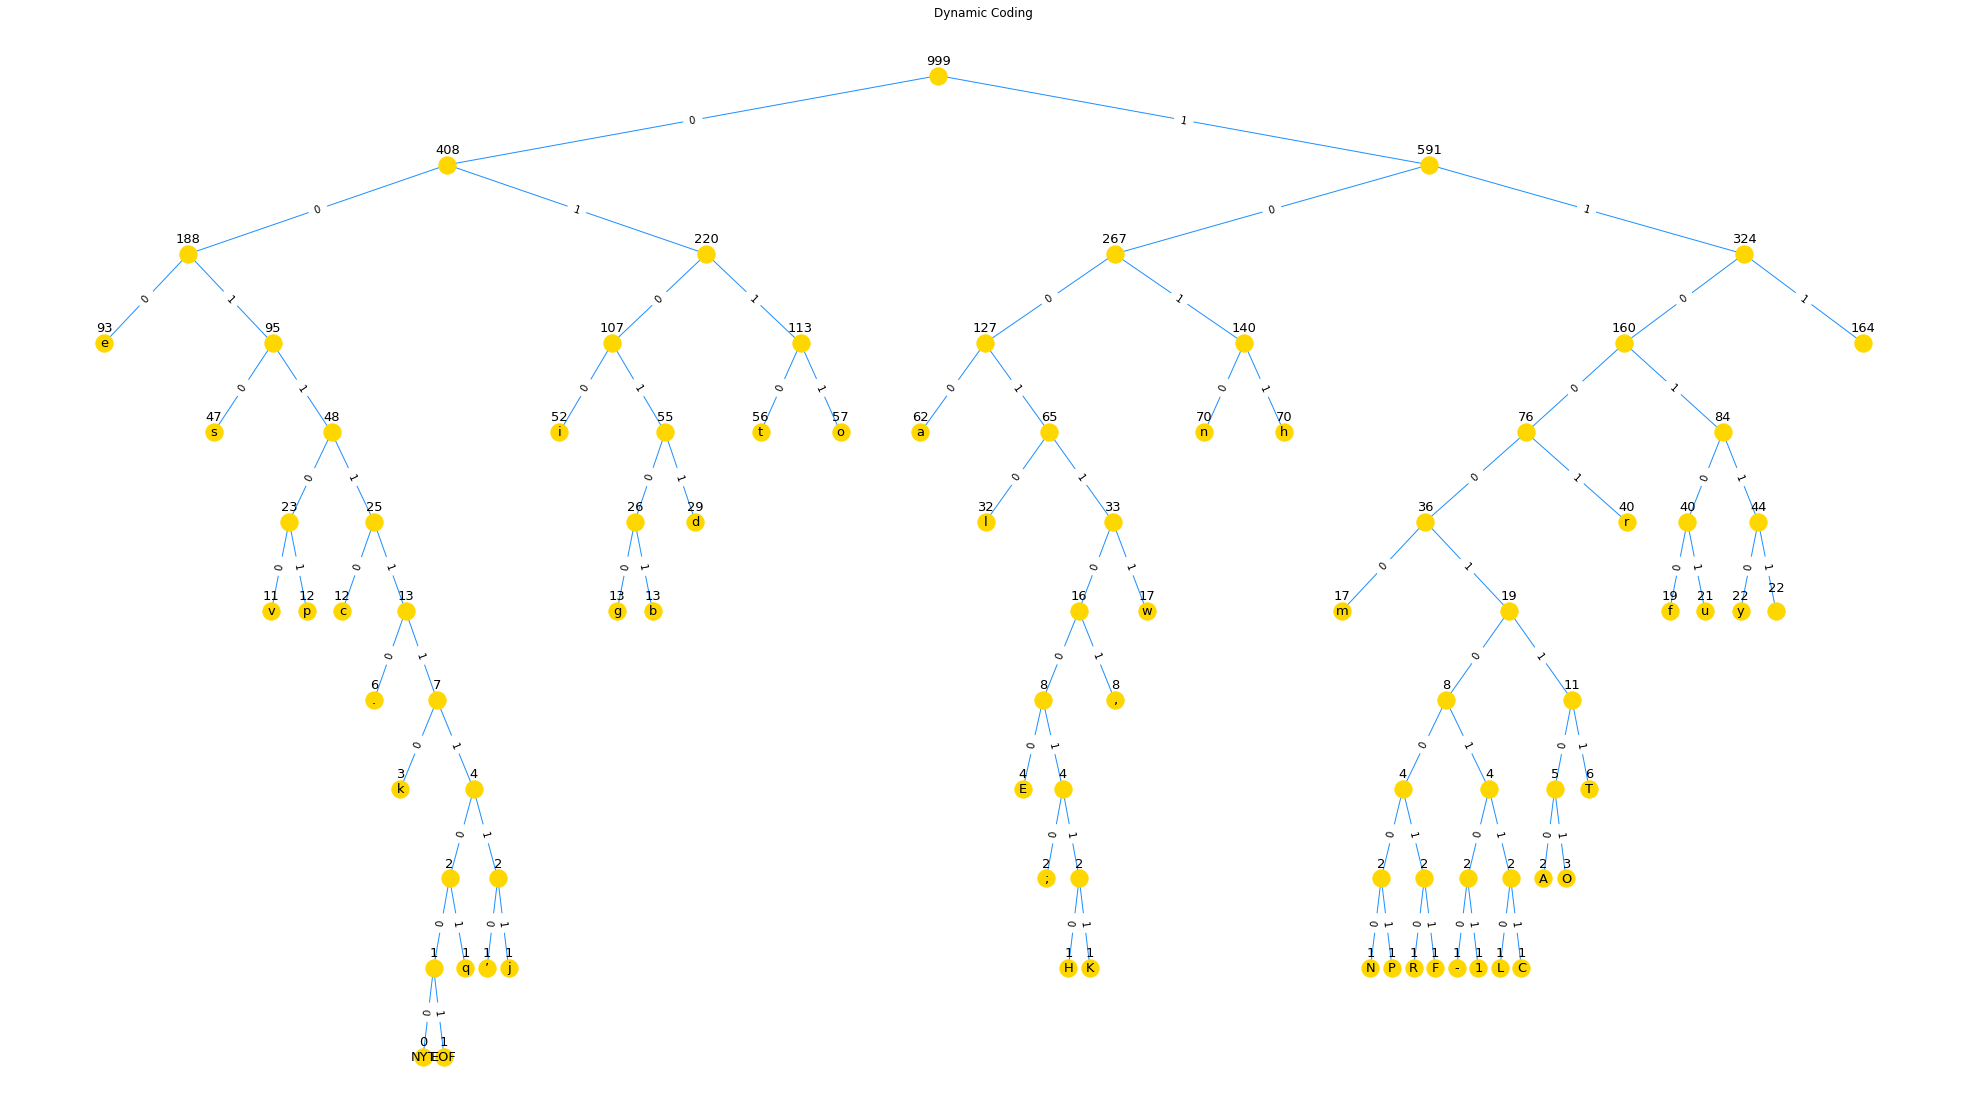

In [15]:
print("\t\t\t\tLarge tree structures for a Huffman coding of a file of size 1kB")
with open ('tests/1kB', 'r') as file:
    one_kilo_text = file.read()

one_kilo_tree_stat = HuffmanTree.build_static_from_text(one_kilo_text)
visualize(one_kilo_tree_stat, width=35, height=20, title="Static Coding")
one_kilo_tree_dynam = HuffmanTree.build_dynamically(one_kilo_text, True)
visualize(one_kilo_tree_dynam, width=35, height=20, title="Dynamic Coding")

## Pomiar czasu

### Funkcje pomiaru czasu

In [16]:
def timeit(method):
    """ 
    Decorator for measuring time.
    It shows arguments of function.
    """
    
    def timed(*args, **kw):
        num_of_meas = 5
        time_measurement = 0.0
        
        for _ in range(num_of_meas):
            ts = time()
            result = None
            result = method(*args, **kw)
            te = time()
            time_measurement += (te - ts) * 1000 / num_of_meas
            
        print("%s%23s \t %10.3f ms" % (method.__name__, ("()").ljust(23), time_measurement))
        return result
    return timed

In [17]:
@timeit
def build_tree_statically(text):
    return HuffmanTree.build_static_from_text(text)

@timeit
def build_tree_dynamically(text):
    return HuffmanTree.build_dynamically(text)

@timeit
def encoding(tree, text):
    return tree.encode(text)

@timeit
def decoding(tree, barray):
    return tree.decode(barray)

In [18]:
def measurements(filenames, tree_build):
    texts = []
    trees = []
    bitarrays = []
    texts_dec = []
    
    for name in filenames:
        with open(name, 'r') as file:
            texts += [file.read()]
            
    print("Time measurement of building Huffman Tree:")
    for i, name in enumerate(filenames):
        print(name + "\t", end = " : ")
        trees += [tree_build(texts[i])]
    
    print("\nTime measurement of compression(with tree already prepared):")
    for i, name in enumerate(filenames):
        print(name + "\t", end = " : ")
        bitarrays += [encoding(trees[i], texts[i])]
        with open(name + "_comp", 'wb') as file:
            bitarrays[-1].tofile(file)
        
        with open(name + "_comp", 'rb') as file:
            bitarrays[-1].fromfile(file)
            
    print("\nTime measurement of decompression(with tree already prepared):")
    for i, name in enumerate(filenames):
        print(name + "\t", end = " : ")
        texts_dec += [decoding(trees[i], bitarrays[i])]

    print("\nAre the text and decompressed text the same:")
    texts_dec = list(map(lambda pair: pair[0] == pair[1], zip(texts_dec, texts)))
    for i, name in enumerate(filenames):
        print(f"{name}\t : {texts_dec[i]}")
        
    print("\nCompression Rate inverses:")
    for i, name in enumerate(filenames):
        print(f"{name}\t : {os.stat(name + '_comp').st_size / os.stat(name).st_size * 100 : .2f}%") 

### Właściwe pomiary

In [19]:
measurements(['tests/1kB', 'tests/10kB', 'tests/100kB', 'tests/1MB'], build_tree_statically)

Time measurement of building Huffman Tree:
tests/1kB	 : build_tree_statically()                      	      0.256 ms
tests/10kB	 : build_tree_statically()                      	      0.927 ms
tests/100kB	 : build_tree_statically()                      	      9.363 ms
tests/1MB	 : build_tree_statically()                      	     91.907 ms

Time measurement of compression(with tree already prepared):
tests/1kB	 : encoding()                      	      0.207 ms
tests/10kB	 : encoding()                      	      1.794 ms
tests/100kB	 : encoding()                      	     25.276 ms
tests/1MB	 : encoding()                      	    258.195 ms

Time measurement of decompression(with tree already prepared):
tests/1kB	 : decoding()                      	      1.109 ms
tests/10kB	 : decoding()                      	     16.298 ms
tests/100kB	 : decoding()                      	    137.799 ms
tests/1MB	 : decoding()                      	   1414.715 ms

Are the text and decompressed text th

Testy zostały wykonane dla odpowiedniej wielkości fragmentów angielskiego tłumaczenia powieści Lwa Tołstoja "Anna Karenina". Podobieństwo stopnia kompresji wynika ze struktury języka angielskiego. Poniżej przykład wygenerowany przy pomocy /dev/urandom.

In [20]:
measurements(['tests/Random_1kB', 'tests/Random_10kB', 'tests/Random_100kB', 'tests/Random_1MB'], build_tree_statically)

Time measurement of building Huffman Tree:
tests/Random_1kB	 : build_tree_statically()                      	      0.360 ms
tests/Random_10kB	 : build_tree_statically()                      	      0.996 ms
tests/Random_100kB	 : build_tree_statically()                      	      9.346 ms
tests/Random_1MB	 : build_tree_statically()                      	     87.378 ms

Time measurement of compression(with tree already prepared):
tests/Random_1kB	 : encoding()                      	      0.178 ms
tests/Random_10kB	 : encoding()                      	      2.420 ms
tests/Random_100kB	 : encoding()                      	     25.904 ms
tests/Random_1MB	 : encoding()                      	    192.269 ms

Time measurement of decompression(with tree already prepared):
tests/Random_1kB	 : decoding()                      	      1.649 ms
tests/Random_10kB	 : decoding()                      	     22.068 ms
tests/Random_100kB	 : decoding()                      	    213.215 ms
tests/Random_1MB	 : de

Jak widać randomizowany tekst ma mniejszy współczynnik kompresji. Prawdopodobnie wynika to z tego, że w języku naturalnym częstotliwość występowania liter jest zróżnicowana, co przy kompresji pozwala zastąpić dużą ich część za pomocą krótkiego kodowania, co jest niemożliwe w przypadku losowego tekstu, gdyż mniej więcej równa ilość każdego znaku pociąga za sobą mniej więcej równe długości kodowania tychże znaków, co skutkuje nieznaczną kompresją. Wciąż jednak jest obserwowana poprawa w stosunku do stanu sprzed kompresji.

In [42]:
measurements(['tests/1kB', 'tests/10kB', 'tests/100kB', 'tests/1MB'], build_tree_dynamically)

Time measurement of building Huffman Tree:
1kB	 : build_tree_dynamically()                      	     12.655 ms
10kB	 : build_tree_dynamically()                      	     89.070 ms
100kB	 : build_tree_dynamically()                      	    992.164 ms
1MB	 : build_tree_dynamically()                      	   9280.127 ms

Time measurement of compression(with tree already prepared):
1kB	 : encoding()                      	      0.508 ms
10kB	 : encoding()                      	      4.874 ms
100kB	 : encoding()                      	     50.977 ms
1MB	 : encoding()                      	    477.417 ms

Time measurement of decompression(with tree already prepared):
1kB	 : decoding()                      	      3.272 ms
10kB	 : decoding()                      	     32.759 ms
100kB	 : decoding()                      	    321.192 ms
1MB	 : decoding()                      	   3465.184 ms

Are the text and decompressed text the same:
1kB	 : True
10kB	 : True
100kB	 : True
1MB	 : True

Compress

In [21]:
measurements(['tests/Random_1kB', 'tests/Random_10kB', 'tests/Random_100kB', 'tests/Random_1MB'], build_tree_dynamically)

Time measurement of building Huffman Tree:
tests/Random_1kB	 : build_tree_dynamically()                      	      5.396 ms
tests/Random_10kB	 : build_tree_dynamically()                      	     44.523 ms
tests/Random_100kB	 : build_tree_dynamically()                      	    470.478 ms
tests/Random_1MB	 : build_tree_dynamically()                      	   4523.836 ms

Time measurement of compression(with tree already prepared):
tests/Random_1kB	 : encoding()                      	      0.198 ms
tests/Random_10kB	 : encoding()                      	      1.857 ms
tests/Random_100kB	 : encoding()                      	     19.096 ms
tests/Random_1MB	 : encoding()                      	    217.736 ms

Time measurement of decompression(with tree already prepared):
tests/Random_1kB	 : decoding()                      	      1.556 ms
tests/Random_10kB	 : decoding()                      	     14.328 ms
tests/Random_100kB	 : decoding()                      	    145.807 ms
tests/Random_1MB	 

<b> Poniżej przedstawiam wyniki, przy użyciu wyszukiwania opytmalnego wierzchołka do zamiany o tej samej częstotliwości występowania w procedurze increment().
    Jest tylko o 4 punkty procentowe wydajniejsza niż przy użyciu FGK i sprawdzaniu rodzeństwa aktualnego wierzchołka oraz rodzeństwa jego rodzica.
</b>

In [37]:
@timeit
def build_dynamically_vitters(text):
    return HuffmanTree.build_dynamically(text, vitter_workalike=True)

measurements(['tests/1kB', 'tests/10kB', 'tests/100kB', 'tests/1MB'], build_dynamically_vitters)

Time measurement of building Huffman Tree:
1kB	 : build_dynamically_vitters_on()                      	    198.486 ms
10kB	 : build_dynamically_vitters_on()                      	   2692.071 ms
100kB	 : build_dynamically_vitters_on()                      	  33334.927 ms
1MB	 : build_dynamically_vitters_on()                      	 411743.685 ms

Time measurement of compression(with tree already prepared):
1kB	 : encoding()                      	      0.465 ms
10kB	 : encoding()                      	      4.968 ms
100kB	 : encoding()                      	     46.378 ms
1MB	 : encoding()                      	    435.441 ms

Time measurement of decompression(with tree already prepared):
1kB	 : decoding()                      	      3.131 ms
10kB	 : decoding()                      	     28.533 ms
100kB	 : decoding()                      	    317.708 ms
1MB	 : decoding()                      	   3064.953 ms

Are the text and decompressed text the same:
1kB	 : True
10kB	 : True
100kB	 : Tr

#### Bibliography
* [1] Huffman, D. A. (1952). *A Method for the Construction of Minimum-Redundancy Codes.* Proceedings of the Institute of Radio Engineers, 40, 1098-1101.
* [2] Jeffrey Scott Vitter. 1987. *Design and analysis of dynamic Huffman codes.* J. ACM 34, 4 (Oct. 1987), 825–845.
* [3] M. Crochemore and W. Rytter, *Text Algorithms*, Oxford University Press, New York, 1994.